### Look at an Existing Backend

In [1]:
from qiskit import IBMQ
from qiskit.tools.jupyter import *
from qiskit.test.mock import FakeAthens
from qiskit.transpiler import CouplingMap
import pprint
pp = pprint.PrettyPrinter(indent=4)

# Define a simulated noisy backend
simulated_backend = FakeAthens()



# Print out basic features of this backend. 
print("---------------------------------Backend Configuration---------------------------------")

config = simulated_backend.configuration()
pp.pprint(config.to_dict())

print("This backend is called {0}, and is on version {1}. \nIt has {2} qubit{3}. \nIt "
      "{4} OpenPulse programs. \nThe basis gates supported on this device are {5}. \nCoupling Map: {6}\n\n"
      "".format(config.backend_name,
                config.backend_version,
                config.n_qubits,
                '' if config.n_qubits == 1 else 's',
                'supports' if config.open_pulse else 'does not support',
                config.basis_gates,
                config.coupling_map))
cm = CouplingMap(config.coupling_map)


print("---------------------------------Backend Properties---------------------------------")
# Print out information about the Properties of the backend.
properties = simulated_backend.properties()

pp.pprint(properties.to_dict())


---------------------------------Backend Configuration---------------------------------
{   'acquisition_latency': [],
    'allow_object_storage': True,
    'allow_q_object': True,
    'backend_name': 'fake_athens',
    'backend_version': '1.3.13',
    'basis_gates': ['id', 'rz', 'sx', 'x', 'cx', 'reset'],
    'channels': {   'acquire0': {   'operates': {'qubits': [0]},
                                    'purpose': 'acquire',
                                    'type': 'acquire'},
                    'acquire1': {   'operates': {'qubits': [1]},
                                    'purpose': 'acquire',
                                    'type': 'acquire'},
                    'acquire2': {   'operates': {'qubits': [2]},
                                    'purpose': 'acquire',
                                    'type': 'acquire'},
                    'acquire3': {   'operates': {'qubits': [3]},
                                    'purpose': 'acquire',
                                

### Make our own Backend

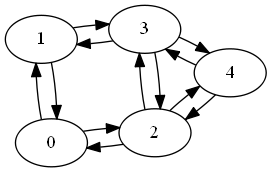

In [2]:
from qiskit.providers import BaseBackend
from qiskit.providers import BackendV1
from qiskit.providers.models import BackendProperties, BackendConfiguration
from qiskit.providers.models.backendconfiguration import GateConfig
from qiskit.transpiler import CouplingMap

backend_name = "HAD"
backend_version = "1.0"
n_qubits = 5
basis_gates = ['id', 'u1', 'u2', 'u3', 'cx']


#Gate Configs
gate_config1 = GateConfig(name="id", 
                          parameters=[], 
                          qasm_def='gate id q { U(0, 0, 0) q; }',
                          coupling_map=[[0], [1], [2], [3], [4]])

gate_config2 = GateConfig(name="u1", 
                          parameters=['lambda'], 
                          qasm_def='gate u1(lambda) q { U(0, 0, lambda) q; }',
                          coupling_map=[[0], [1], [2], [3], [4]])

gate_config3 = GateConfig(name="u2", 
                          parameters=['phi', 'lambda'], 
                          qasm_def='gate u2(phi, lambda) q { U(pi/2, phi, '
                                   'lambda) q; }',
                          coupling_map=[[0], [1], [2], [3], [4]])

gate_config4 = GateConfig(name="u3", 
                          parameters=['theta', 'phi', 'lambda'], 
                          qasm_def='gate u3(theta, phi, lambda) q { U(theta, '
                                   'phi, lambda) q; }',
                          coupling_map=[[0], [1], [2], [3], [4]])

gate_config5 = GateConfig(name="cx", 
                          parameters=[], 
                          qasm_def='gate cx q0, q1 { CX q0, q1; }',
                          coupling_map=[[0, 1],
                                        [1, 0],
                                        [0, 2],
                                        [2, 0],
                                        [1, 3],
                                        [3, 1],
                                        [2, 3],
                                        [3, 2],
                                        [2, 4],
                                        [4, 2],
                                        [3, 4],
                                        [4, 3]])

gates = [gate_config1, gate_config2, gate_config3, gate_config4, gate_config5]

coupling_map = [[0, 1],
                [1, 0],
                [0, 2],
                [2, 0],
                [1, 3],
                [3, 1],
                [2, 3],
                [3, 2],
                [2, 4],
                [4, 2],
                [3, 4],
                [4, 3]]

backendConfig = BackendConfiguration(backend_name=backend_name, 
                                     backend_version=backend_version,
                                     n_qubits=n_qubits,
                                     basis_gates=basis_gates,
                                     gates=gates,
                                     local=True,
                                     simulator=True,
                                     conditional=True,
                                     open_pulse=True,
                                     memory=True,
                                     max_shots=1024,
                                     coupling_map=coupling_map
                                     );
# Does not work. Missing _default_options method and run method. Must define these.
#HAD_Backend = BackendV1(configuration=backendConfig)
class HAD_Backend(BackendV1):
    def _default_options(cls):
        pass
    
    def run(self, run_input, **options):
        return run_input.qasm()

        
    
HAD_custom_backend = HAD_Backend(configuration=backendConfig)

cm = CouplingMap(backendConfig.coupling_map)
cm.draw()

Untranspiled
Depth: 6
Gate counts: OrderedDict([('h', 7), ('measure', 3), ('barrier', 2), ('cx', 2), ('z', 1), ('id', 1)])


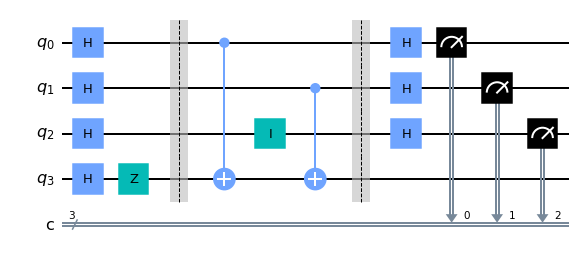

In [3]:
# For Passes
from qiskit import QuantumCircuit
from qiskit.compiler import transpile
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller



### Lets defined a new circuit of your choice with no measurements

s = '011'   # the hidden binary string
n = 3 # number of bits used to represent s


# We need a circuit with n qubits, plus one auxiliary qubit
# We also need n classical bits to write the output to
untranspiled_qc = QuantumCircuit(n+1, n)

# Put auxiliary in the minus state |->
# We leave the other n qubits in just |0>
untranspiled_qc.h(n)
untranspiled_qc.z(n)

# Apply Hadamard gates to each of the n "main" qubits (excluding the auxiliary)
# before querying the oracle
for i in range(n):
    untranspiled_qc.h(i)
    
# Apply barrier
untranspiled_qc.barrier()

# Apply the inner-product oracle
s = s[::-1] # reverse s to fit qiskit's qubit ordering
for q in range(n):
    if s[q] == '0':
        untranspiled_qc.i(q)
    else:
        untranspiled_qc.cx(q, n)
        
# Apply barrier
untranspiled_qc.barrier()

# Apply Hadamard gates after querying the oracle
for i in range(n):
    untranspiled_qc.h(i)


# Measurement
for i in range(n):
    untranspiled_qc.measure(i, i)


untranspiled_qc = transpile(untranspiled_qc, backend=None)  # No Optimization and no mapping because we have not specified a backend.
print('Untranspiled')
print('Depth:', untranspiled_qc.depth())
print('Gate counts:', untranspiled_qc.count_ops())
untranspiled_qc.draw("mpl")

In [4]:
#printf(HAD_custom_backend.run())


Transpiled
Depth: 10
Gate counts: OrderedDict([('cx', 8), ('u2', 7), ('barrier', 3), ('measure', 3)])


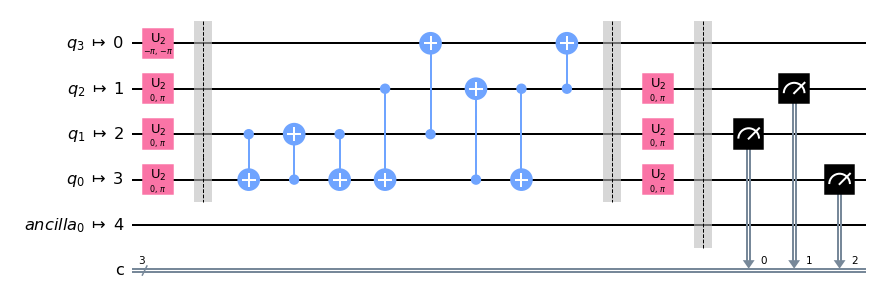

In [5]:
transpiled_qc = transpile(untranspiled_qc, HAD_custom_backend)
print('Transpiled')
print('Depth:', transpiled_qc.depth())
print('Gate counts:', transpiled_qc.count_ops())
transpiled_qc.draw("mpl")

In [6]:
# 3) Now, we can execute the transpiled circuit on the simulated noisy backend
results = HAD_custom_backend.run(transpiled_qc)#.result()
print(results)

OPENQASM 2.0;
include "qelib1.inc";
qreg q[5];
creg c[3];
u2(-pi,-pi) q[0];
u2(0,pi) q[1];
u2(0,pi) q[2];
u2(0,pi) q[3];
barrier q[0],q[1],q[2],q[3];
cx q[2],q[3];
cx q[3],q[2];
cx q[2],q[3];
cx q[1],q[3];
cx q[2],q[0];
cx q[3],q[1];
cx q[1],q[3];
cx q[1],q[0];
barrier q[0],q[3],q[1],q[2];
u2(0,pi) q[1];
u2(0,pi) q[2];
u2(0,pi) q[3];
barrier q[1],q[3],q[4],q[0],q[2];
measure q[2] -> c[0];
measure q[1] -> c[1];
measure q[3] -> c[2];



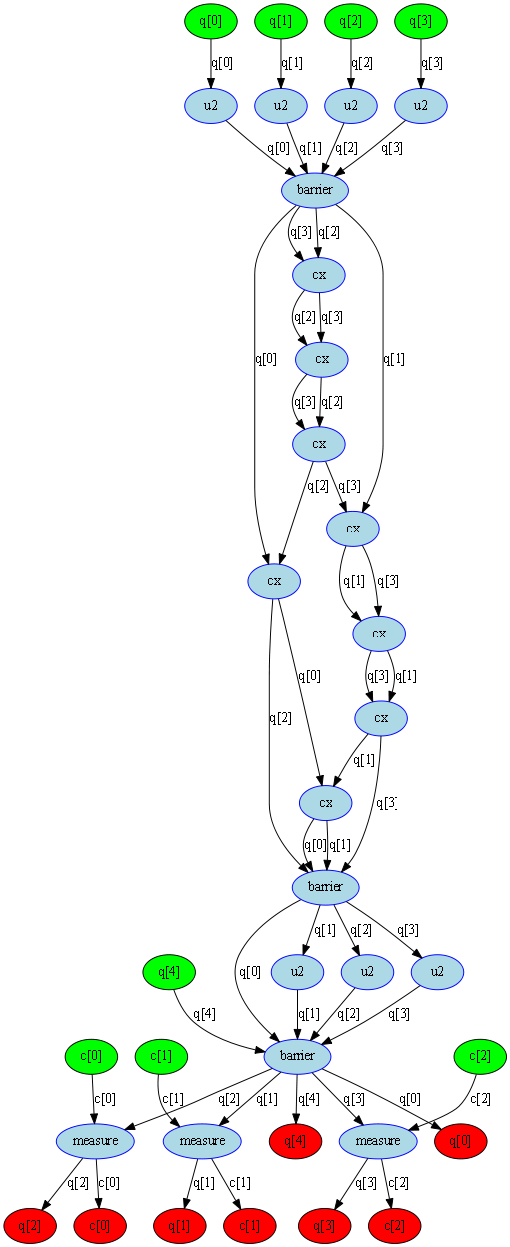

In [8]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.dagcircuit import DAGCircuit
from qiskit.converters import circuit_to_dag
from qiskit.tools.visualization import dag_drawer

# Required software to visually see DAG
!pip install pydot

# Draw DAG of the transpiled circuit that used optimization_level=0
dag = circuit_to_dag(transpiled_qc)
dag_drawer(dag)

In [7]:
from qiskit.tools.visualization import plot_histogram

counts = results.get_counts()
plot_histogram(counts)

AttributeError: 'str' object has no attribute 'get_counts'

In [ ]:
#Gate Configs used by FakeAthens
''' 
basis_gates = ['id', 'rz', 'sx', 'x', 'cx', 'reset']

gate_config1 = GateConfig(name="id", 
                          parameters=[], 
                          qasm_def='gate id q { U(0, 0, 0) q; }',
                          coupling_map=[[0], [1], [2], [3], [4]])

gate_config2 = GateConfig(name="rz", 
                          parameters=['theta'], 
                          qasm_def='gate rz(theta) q { U(0, 0, theta) q; }',
                          coupling_map=[[0], [1], [2], [3], [4]])

gate_config3 = GateConfig(name="sx", 
                          parameters=[], 
                          qasm_def='gate sx q { U(pi/2, 3*pi/2, pi/2) q; }',
                          coupling_map=[[0], [1], [2], [3], [4]])

gate_config4 = GateConfig(name="x", 
                          parameters=[], 
                          qasm_def='gate x q { U(pi, 0, pi) q; }',
                          coupling_map=[[0], [1], [2], [3], [4]])

gate_config5 = GateConfig(name="cx", 
                          parameters=[], 
                          qasm_def='gate cx q0, q1 { CX q0, q1; }',
                          coupling_map=[[0, 1],
                                        [1, 0],
                                        [0, 2],
                                        [2, 0],
                                        [1, 3],
                                        [3, 1],
                                        [2, 3],
                                        [3, 2],
                                        [2, 4],
                                        [4, 2],
                                        [3, 4],
                                        [4, 3]])
'''